In [1]:
import networkx as nx
import numpy as np
import pandas as pd

import os
import sys

sys.path.append(os.path.abspath("../../scripts/"))
from oso_db import execute_query

sys.path.append(os.path.abspath("../../visualizations/"))
from contribution_heatmap import contribution_heatmap
from venn_diagram import venn3_diagram

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'sans-serif']

GREEN = "#44D698"
BLUE  = "#2070DD"

# Fetch / update data

In [2]:
# create a mapping of projects to collections
query = """
    SELECT p."slug", c."slug" 
    FROM project p 
    JOIN collection_projects_project cpp ON p."id" = cpp."projectId"
    JOIN collection c ON cpp."collectionId" = c."id"
    WHERE c."typeId" = 1
    """
result = execute_query(query, col_names=False)
cpp = {k: sorted([v for v, key in result if key == k]) for k in set(key for _, key in result)}

Total projects: 566


(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

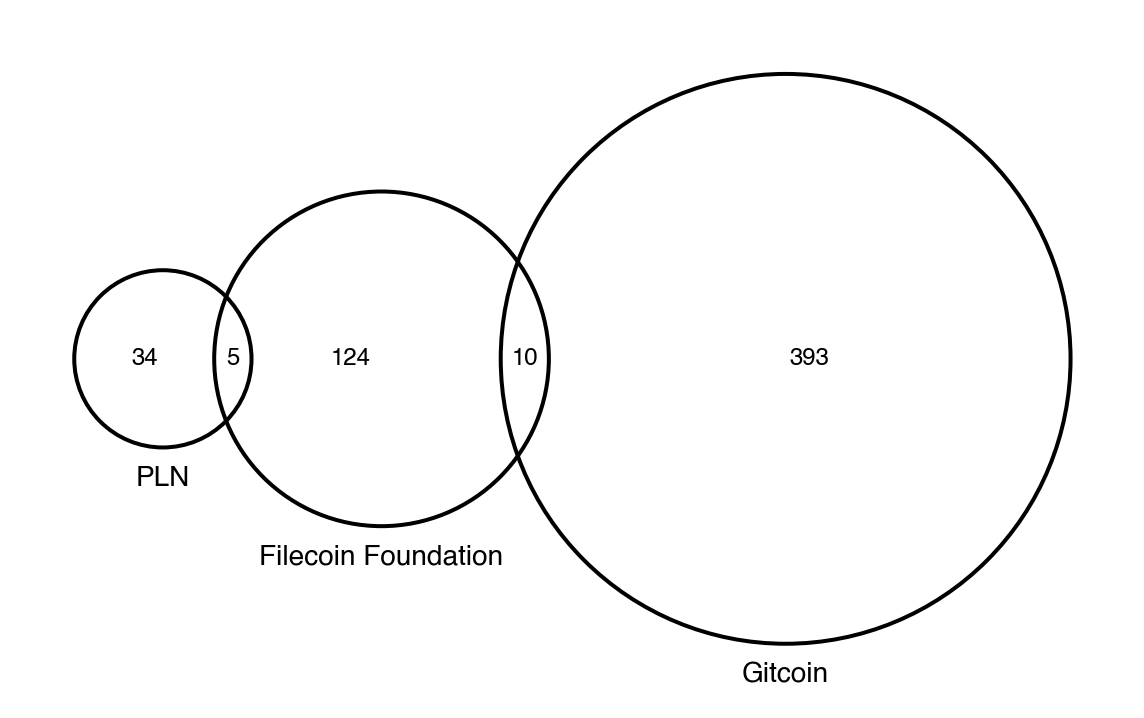

In [6]:
collection_slugs = ["protocol-labs-network", "gitcoin-allo", "filecoin-foundation"]
all_slugs = set([p for c,ps in cpp.items() if c in collection_slugs for p in ps])
total_projects = len(all_slugs)
print("Total projects:", total_projects)

venn3_diagram(
    [set(cpp[c]) for c in collection_slugs], 
    ["PLN", "Gitcoin", "Filecoin Foundation"],
    labelcolor="black",
    fontsize=12
)

In [7]:
ff_slugs = cpp['filecoin-foundation']
ffdw_slugs = cpp['ffdw-grants']
slugs = ff_slugs + ffdw_slugs
slugs = list(set(slugs))
slugs_str = "','".join(slugs)
print(len(slugs))

154


In [8]:
query = f"""
    SELECT "slug", "name"
    FROM project 
    WHERE "slug" IN ('{slugs_str}') 
    """
result = execute_query(query, col_names=False)
slugs_to_names = {x[0]: x[1][:24] for x in result}

In [9]:
START_DATE = "2015-01-01"
END_DATE = "2023-12-31"

# Developer Activity

In [10]:
devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "full_time_developer",
            CASE WHEN COUNT(DISTINCT e."time") < 10 THEN 1 ELSE 0 END AS "part_time_developer"
        FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{slugs_str}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("full_time_developer") AS "Full time developers",
        SUM("part_time_developer") AS "Part time developers"
    FROM Devs
    WHERE month >= '{START_DATE[:-3]}' AND month < '{END_DATE[:-3]}'
    GROUP BY slug, month
    ORDER BY slug, month;
""", col_names=True)

df_devs = pd.DataFrame(devs_query[1:], columns=devs_query[0])
df_devs['sum'] = df_devs['Full time developers'] + df_devs['Part time developers']
df_devs.head()

slug    month  Full time developers  Part time developers  sum
0  0xparc  2015-01                     0                     1    1
1  0xparc  2015-06                     0                     1    1
2  0xparc  2015-07                     0                     1    1
3  0xparc  2015-08                     0                     1    1
4  0xparc  2015-09                     0                     2    2

In [11]:
def annualize_ticks(dataframe, ax):
    months = dataframe['month'].nunique()
    ax.set_xlim([0,months-1])
    ax.set_xticks([x for x in range(0,months,12)])
    xticklabels = [x[:-3] for x in sorted(df_devs['month'].unique())[::12]]
    ax.set_xticklabels(xticklabels)

Text(0.0, 1.0, 'Monthly active developers across Filecoin Foundation projects')

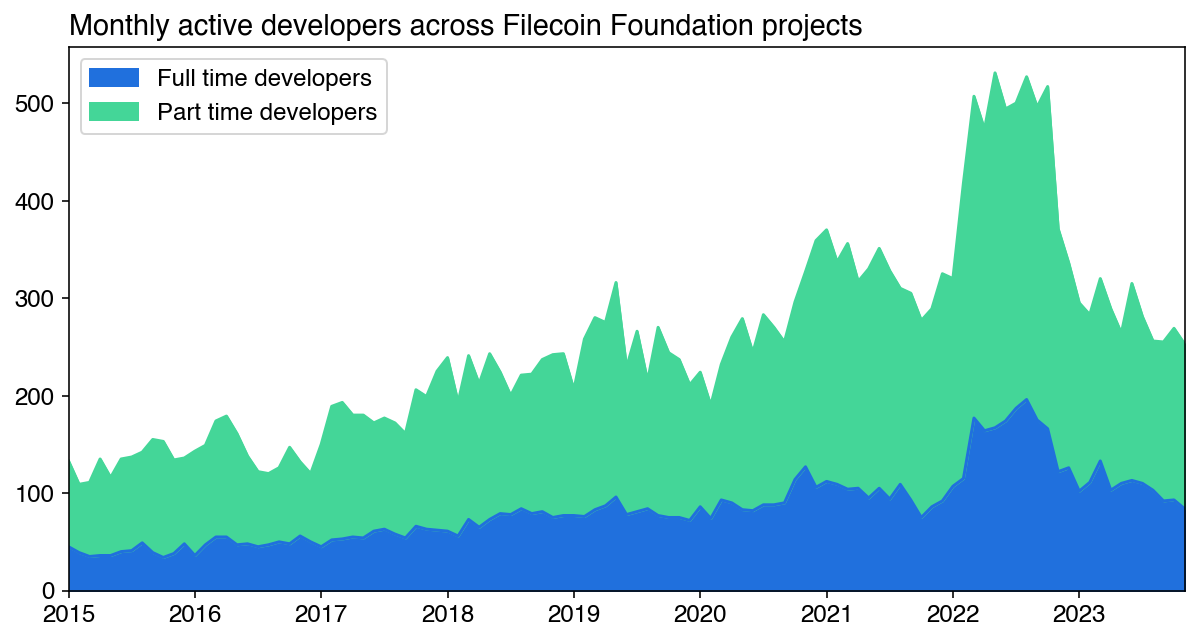

In [12]:
fig, ax = plt.subplots(figsize=(10,5), facecolor='white', dpi=144)
(
    df_devs
    .groupby('month')
    [['Full time developers', 'Part time developers']]
    .sum()
    .plot(
        kind='area', 
        color=[BLUE, GREEN],
        ax=ax
    )
)
annualize_ticks(df_devs, ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Monthly active developers across Filecoin Foundation projects', fontweight="bold", loc='left')

In [13]:
(    
    df_devs
    .groupby('month')
    [['Full time developers', 'Part time developers']]
    .sum()
    .iloc[-1]
)

Full time developers     84
Part time developers    169
Name: 2023-11, dtype: int64

Text(0.0, 1.0, 'Full time developers by project\n')

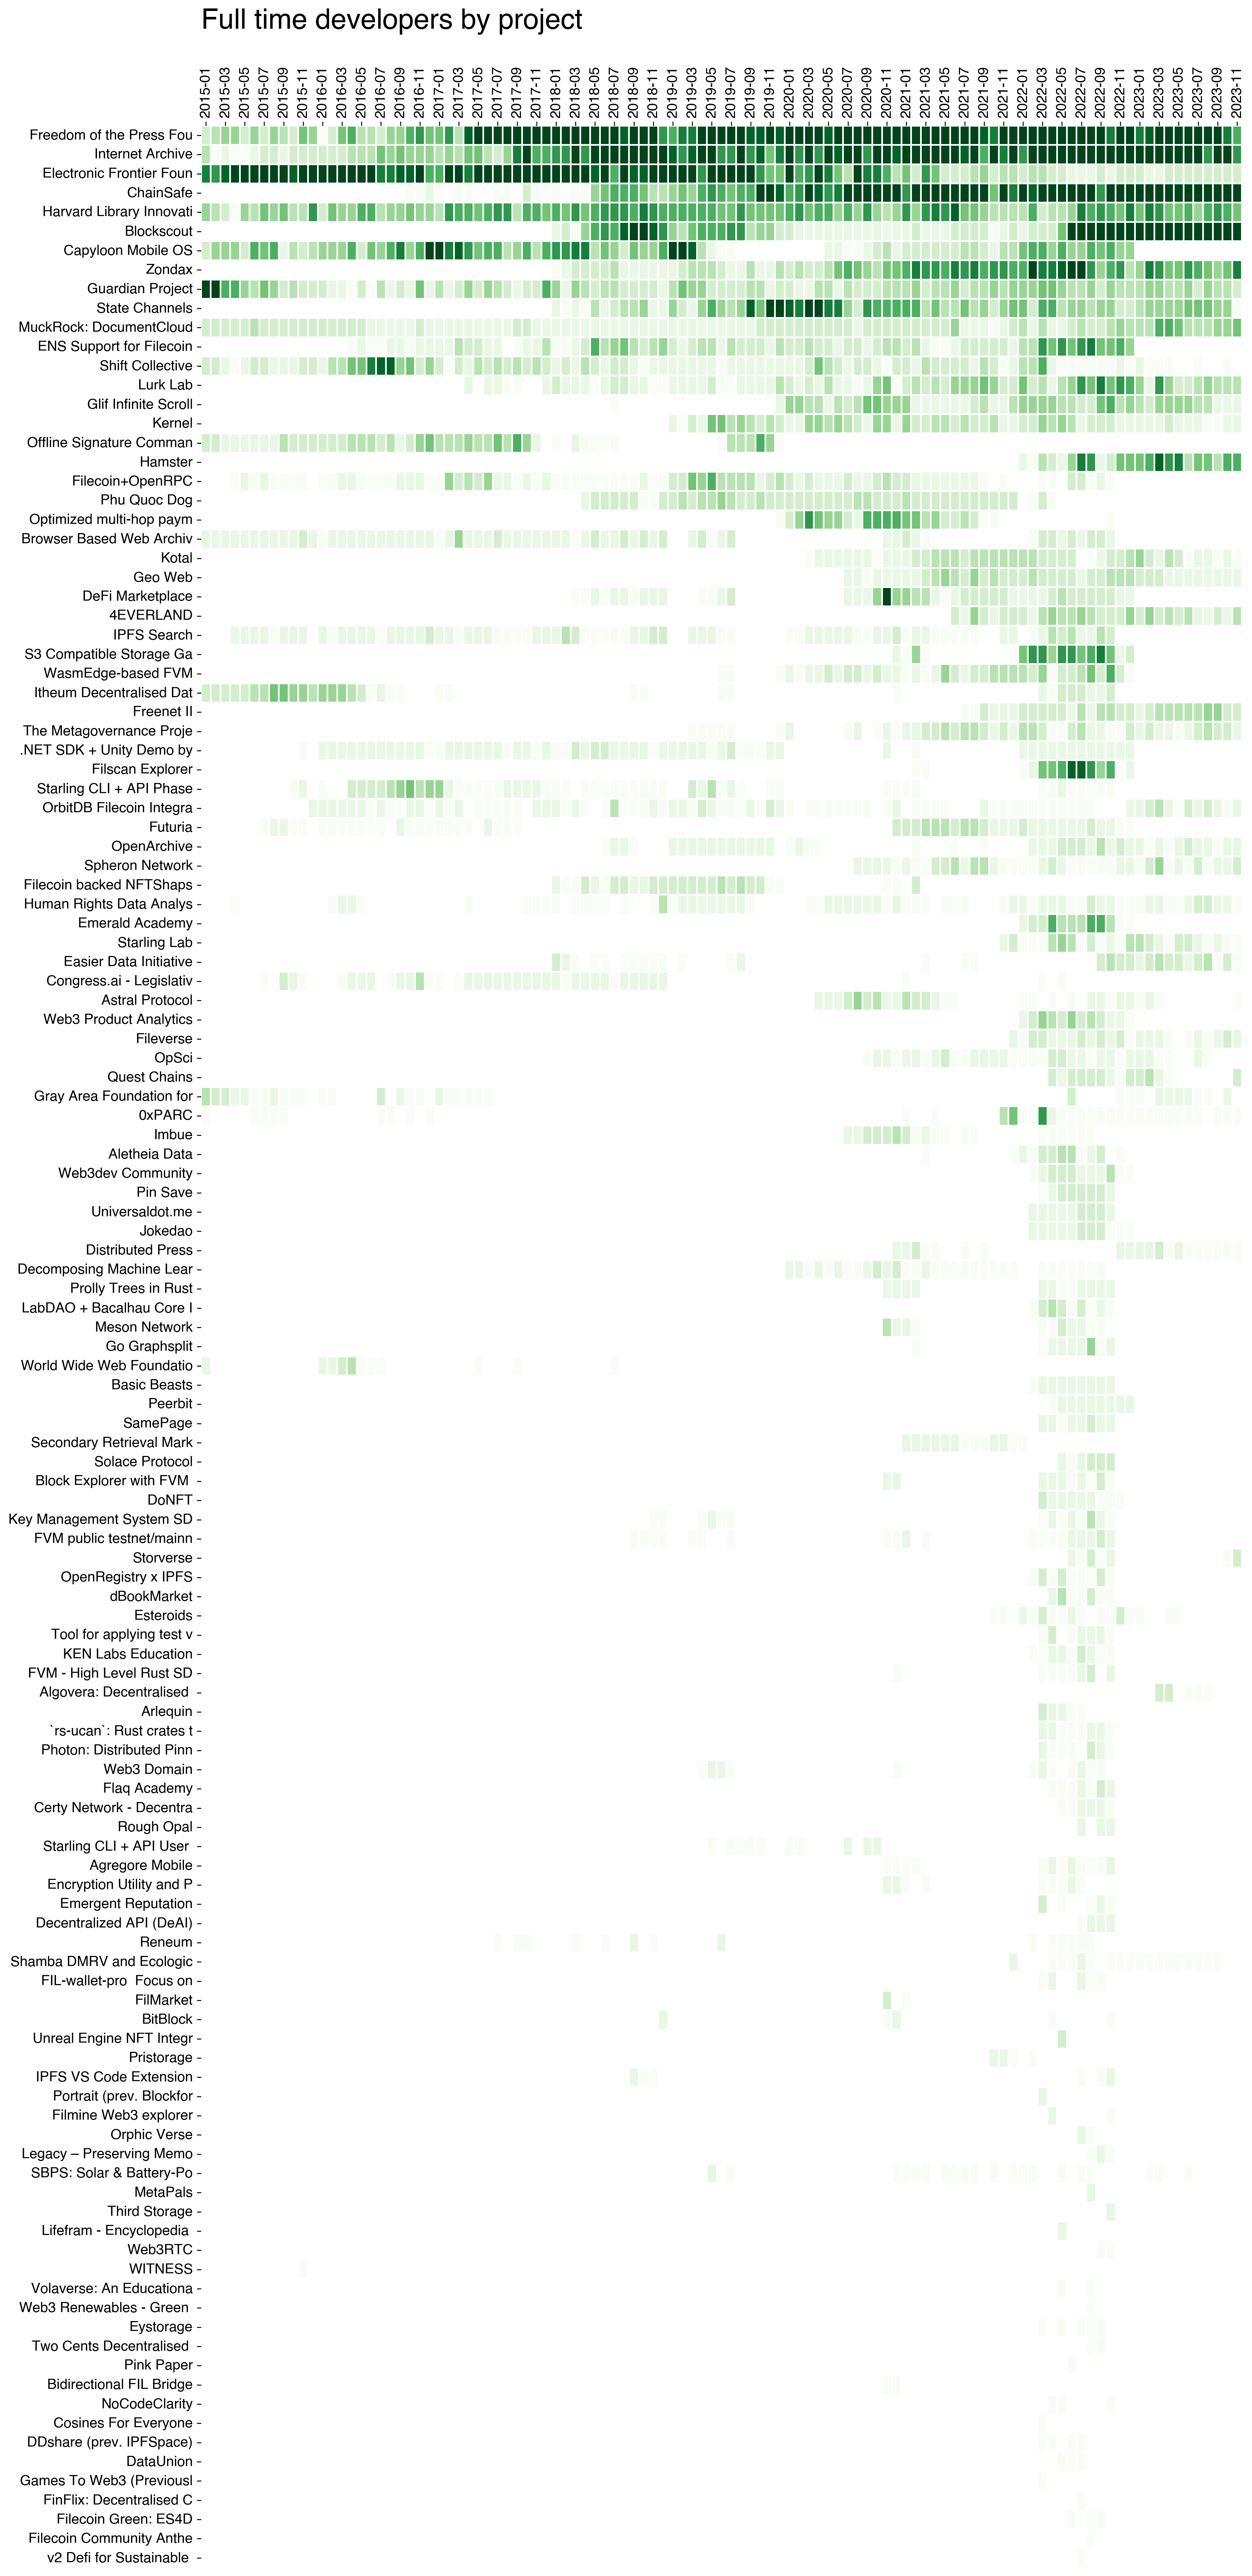

In [17]:
df_devs['project'] = df_devs['slug'].map(slugs_to_names)

fig, ax = contribution_heatmap(
    df_devs,
    index_col='project',
    column_col='month',
    value_col='Full time developers',
    sort_label_method='mean',
    dpi=300,
    cmap='Greens',
    vmax=10,
    figsize=(15,30)
)

ax.set_title("Full time developers by project\n", fontweight="bold", loc='left', fontsize=24)

Text(0.0, 1.0, 'Full time developers by project\n')

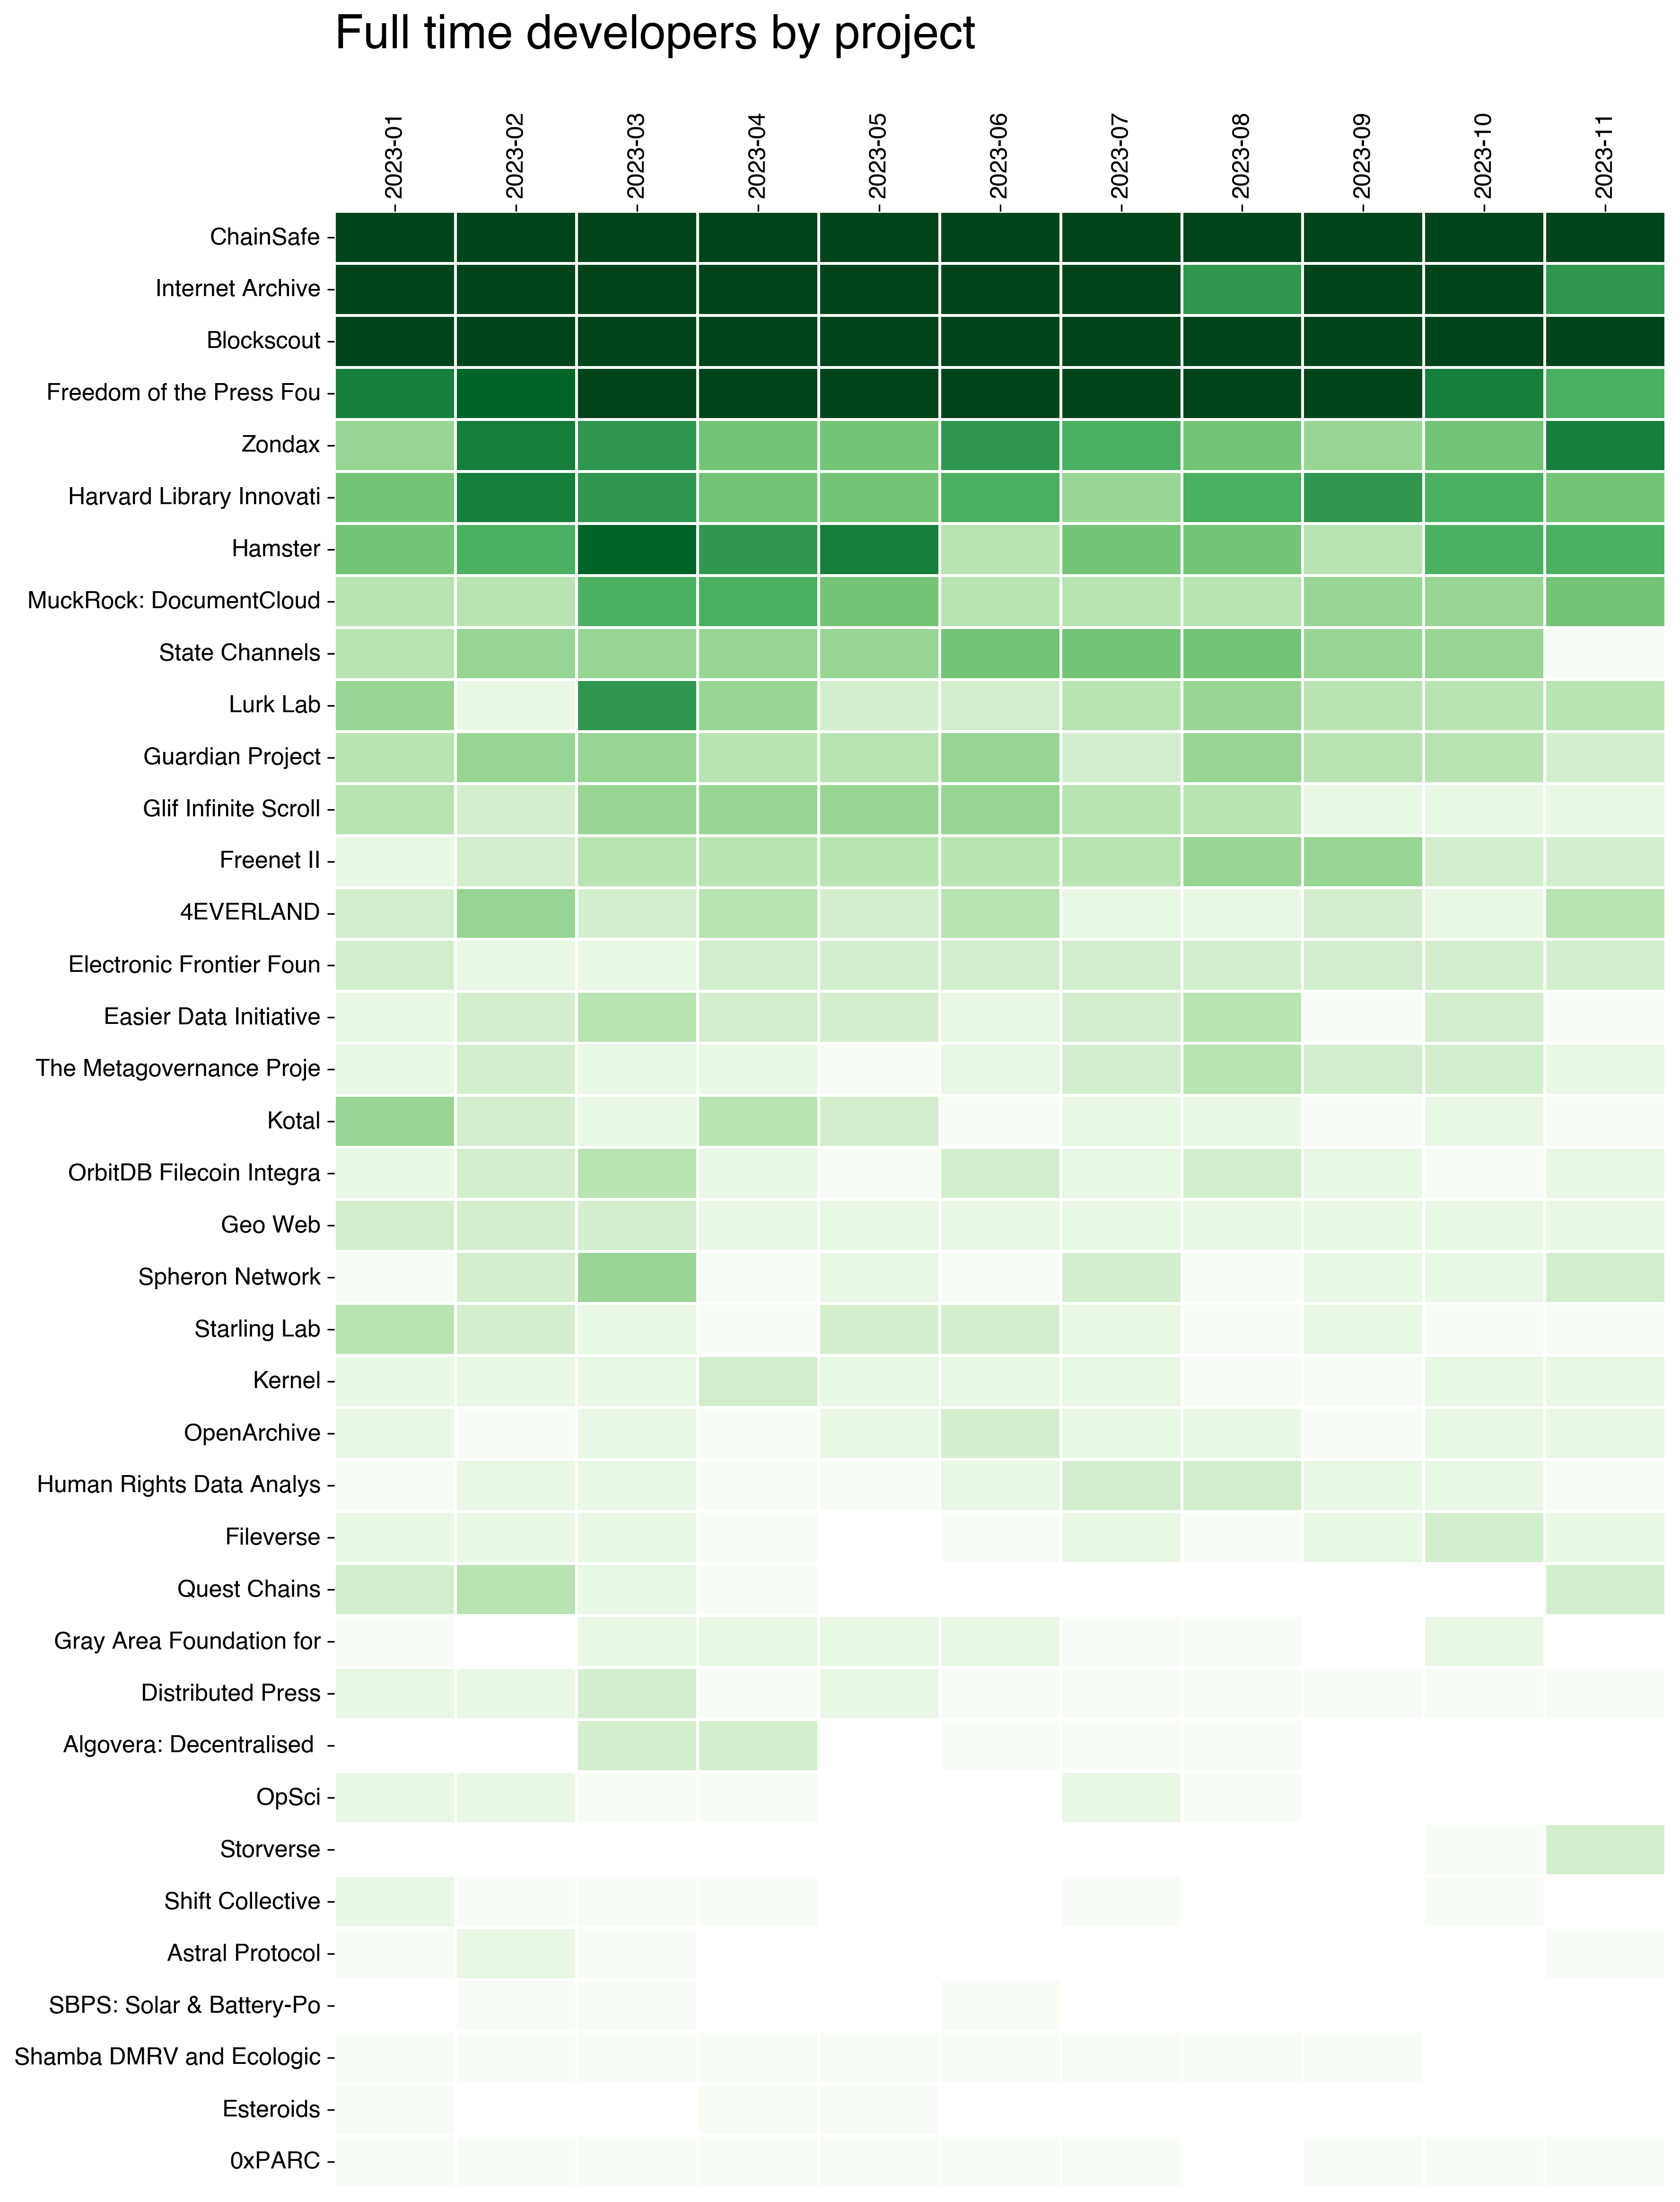

In [25]:
df_devs['project'] = df_devs['slug'].map(slugs_to_names)

fig, ax = contribution_heatmap(
    df_devs.query("month >= '2023-01'"),
    index_col='project',
    column_col='month',
    value_col='Full time developers',
    sort_label_method='mean',
    dpi=300,
    cmap='Greens',
    vmax=10,
    figsize=(12,15)
)

ax.set_title("Full time developers by project\n", fontweight="bold", loc='left', fontsize=24)

# Bonus: discovery

In [18]:
pr_query = execute_query(f"""
    SELECT
        p.slug,
        e."fromId",
        COUNT(DISTINCT e."time") AS contributions,
        MIN(e."time") AS first_contribution
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        p.slug IN ('{slugs_str}')
        AND e."typeId" IN (
            2, -- PR created
            4, -- Commit
            18 -- Issue created
        )
        AND e.time >= '{START_DATE}'
    GROUP BY
        p.slug,
        e."fromId";
""", col_names=True)

In [19]:
# transform query results

df_pr = pd.DataFrame(pr_query[1:], columns=pr_query[0])
slugs_to_names['op'] = 'Op'
df_pr['project'] = df_pr['slug'].map(slugs_to_names)

threshold = 10
df_pr = df_pr[df_pr['contributions']>=threshold].reset_index(drop=True)

contributooors = df_pr.groupby('fromId')['project'].apply(lambda x: len(set(x)))
contributooors = contributooors[contributooors>1].index
df_pr = df_pr[df_pr.fromId.isin(contributooors)]

# build a network graph

nodes = list(slugs)
edges = []

for fromId, group in df_pr.groupby('fromId'):
    project_set = group['project'].tolist()
    project_set.sort(key=lambda x: group[group['project'] == x]['first_contribution'].values[0])
    
    for i in range(len(project_set) - 1):
        project1 = project_set[i]
        project2 = project_set[i + 1]
        contributions1 = group[group['project'] == project1]['contributions'].values[0]
        contributions2 = group[group['project'] == project2]['contributions'].values[0]
        harmonic_mean = 2 * contributions1 * contributions2 / (contributions1 + contributions2) if contributions1 + contributions2 > 0 else 0
        edges.append((project1, project2, harmonic_mean))

(-0.055934095032156766,
 0.12130364438924719,
 -0.17367041193684807,
 0.09910290657349637)

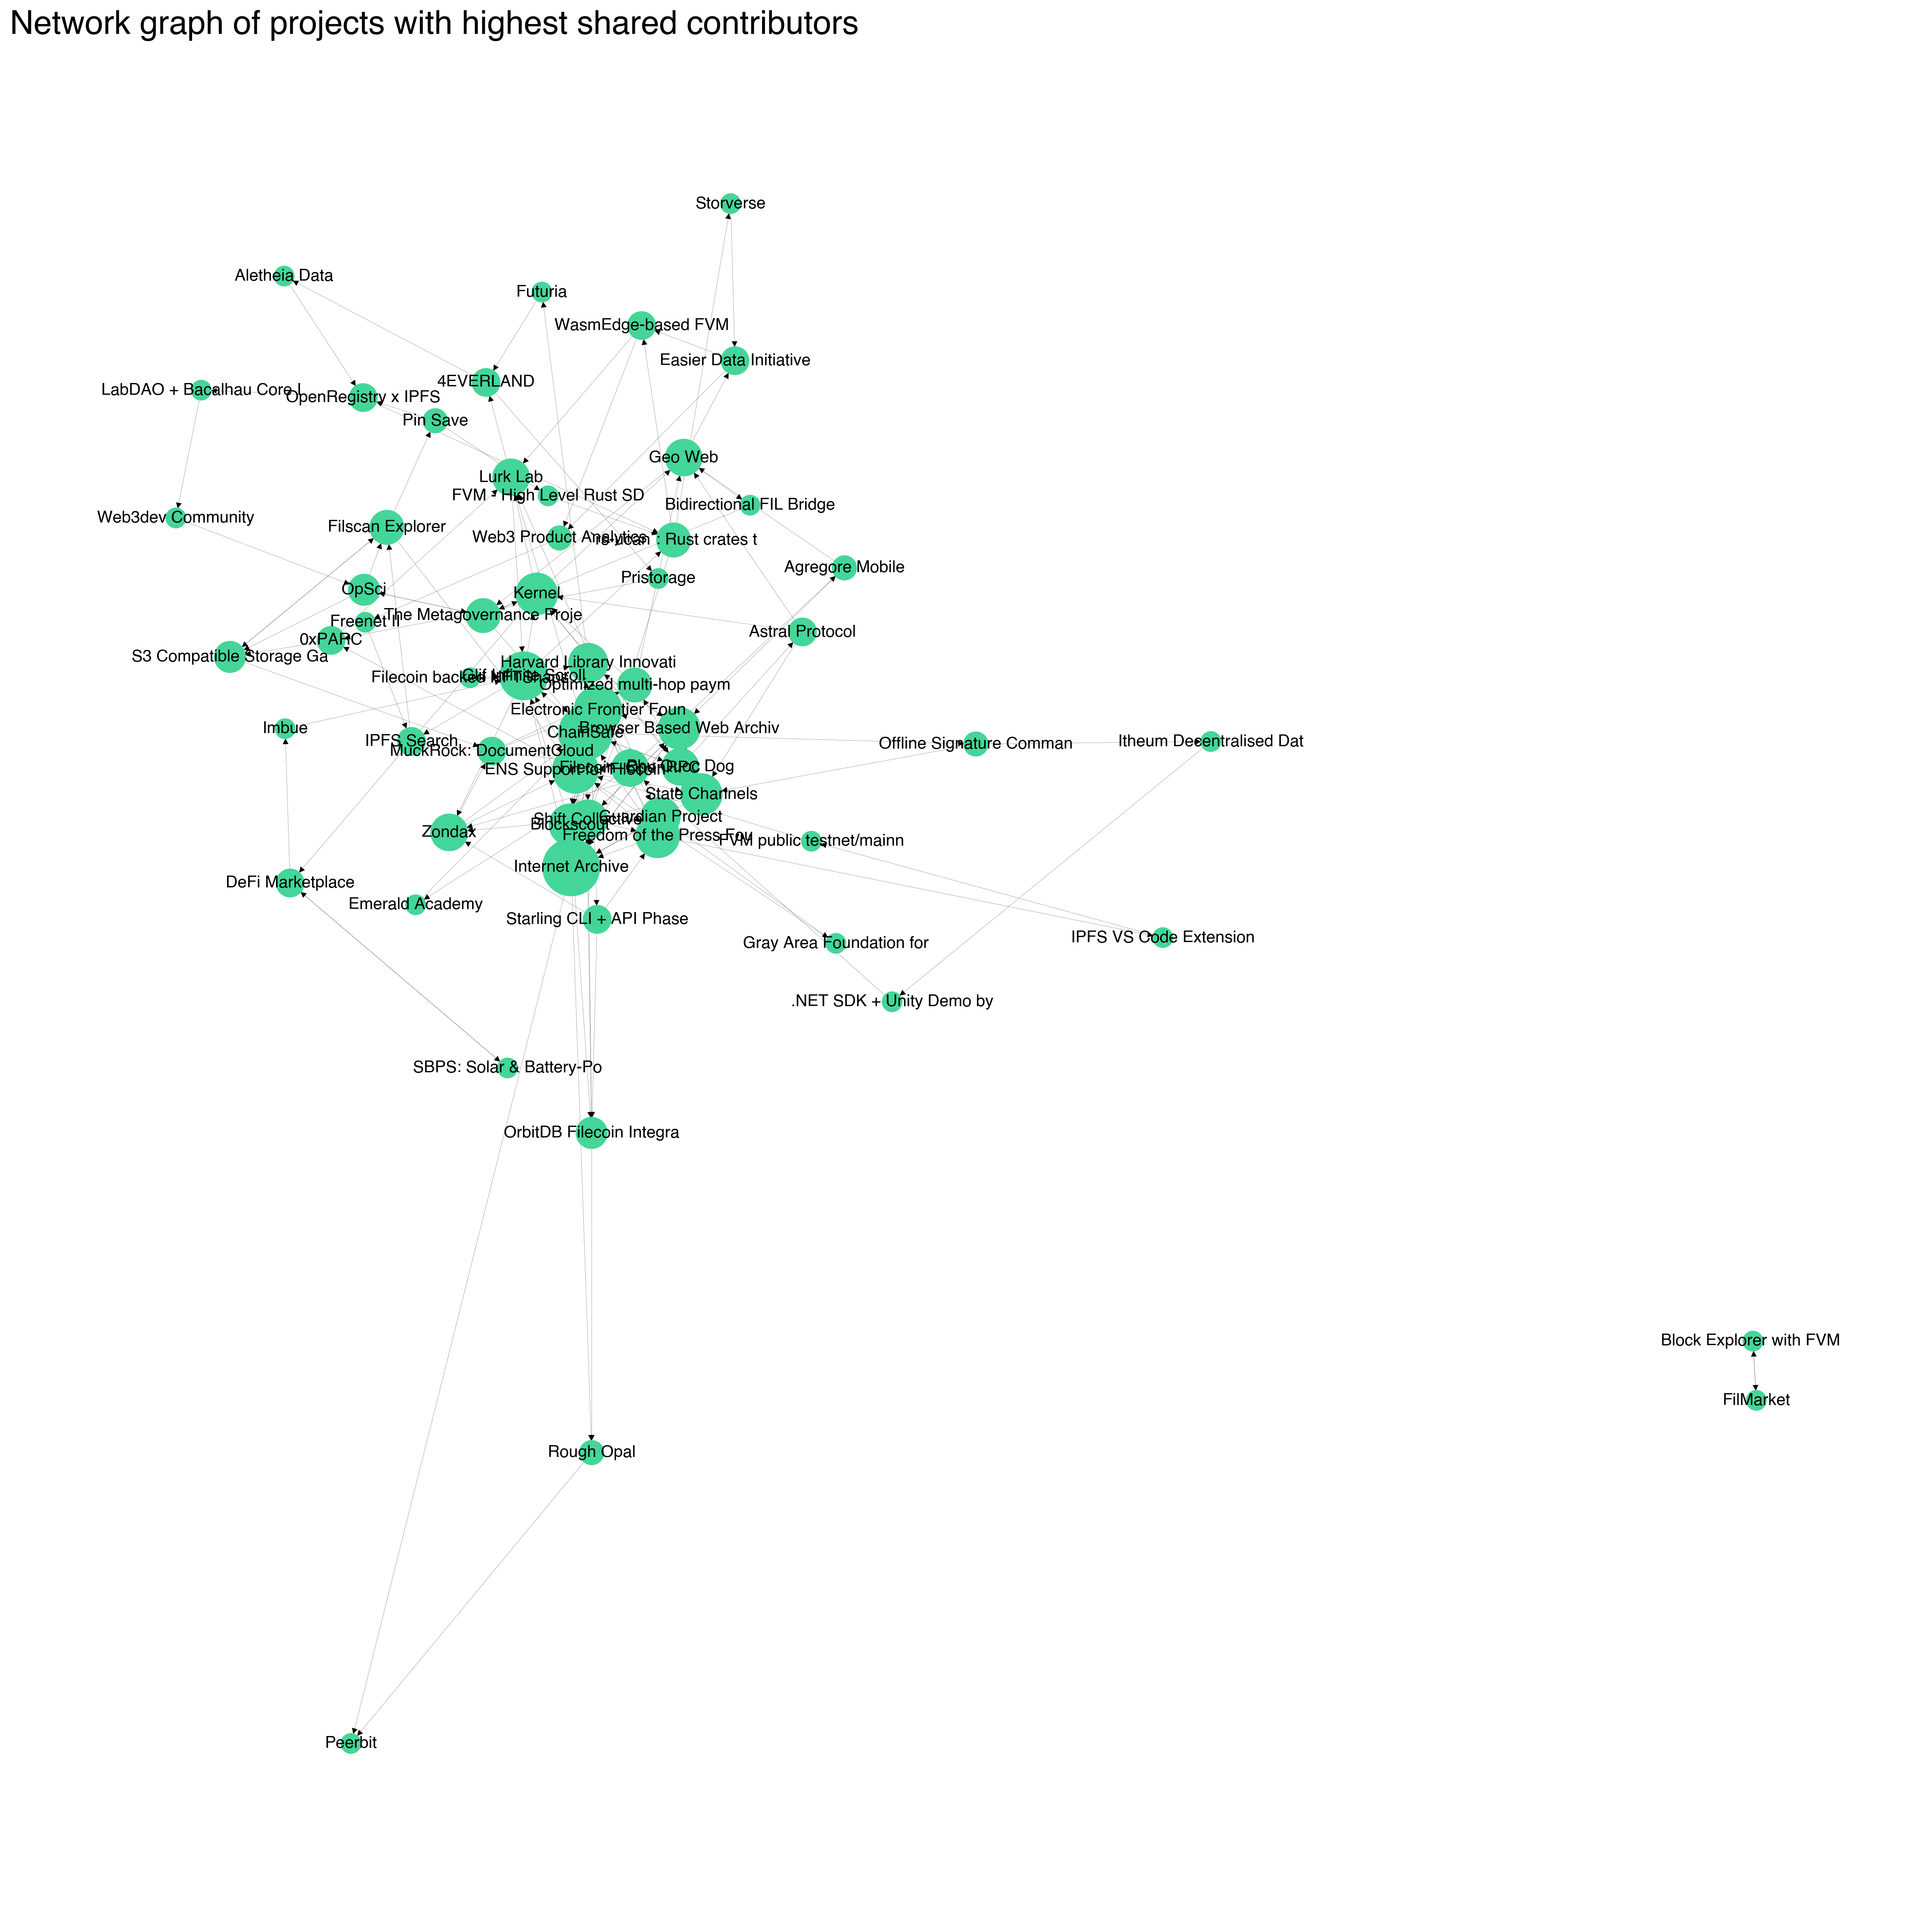

In [27]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

min_degree = 2
G = nx.k_core(G, min_degree)
degrees = dict(G.degree)
pos = nx.spring_layout(G, scale=.15, k=.6)

fig, ax = plt.subplots(figsize=(25,25), dpi=300)
nx.draw_networkx(G, pos, node_size=[degrees[d]*100 for d in degrees], width=.1, node_color="#44D698")
ax.set_title("Network graph of projects with highest shared contributors", fontweight="bold", loc='left', fontsize=24)
plt.axis('off')

In [28]:
top_devs = df_pr.groupby('fromId')['contributions'].sum().sort_values().tail(300).index
top_devs = [str(int(x)) for x in top_devs]

In [29]:
top_devs_str = "','".join(top_devs)
dev_names = execute_query(f"SELECT id, name FROM artifact WHERE id IN ('{top_devs_str}')")

In [30]:
df_active_devs = pd.DataFrame(dev_names[1:], columns=dev_names[0])
df_active_devs = df_active_devs[df_active_devs['name'].str.contains('bot|web-flow|user|team@|unverified|@pm|github')==False]
devs_dict = dict(zip(df_active_devs['id'], df_active_devs['name']))

In [31]:
devs_params = "','".join([str(x) for x in df_active_devs['id'].to_list()])

dev_activity = execute_query(f"""
    SELECT
        "fromId",
        TO_CHAR(DATE_TRUNC('MONTH', time), 'YYYY-MM') AS "month",
        SUM(amount) as "activity"
    FROM event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        "fromId" IN ('{devs_params}')
        AND "typeId" IN (
            2, -- PR created
            4 -- Commit            
        )
        AND time >= '{START_DATE}'
        AND p.slug IN ('{slugs_str}')
    GROUP BY
        "fromId",
        TO_CHAR(DATE_TRUNC('MONTH', time), 'YYYY-MM')
""")

In [32]:
df_dev_activity = pd.DataFrame(dev_activity[1:], columns=dev_activity[0])
shortlist = df_dev_activity.groupby('fromId')['activity'].sum().sort_values().tail(150).index
df_dev_activity = df_dev_activity[df_dev_activity['fromId'].isin(shortlist)]

Text(0.0, 1.0, 'Leading developers in the ecosystem (based on GitHub activity)\n')

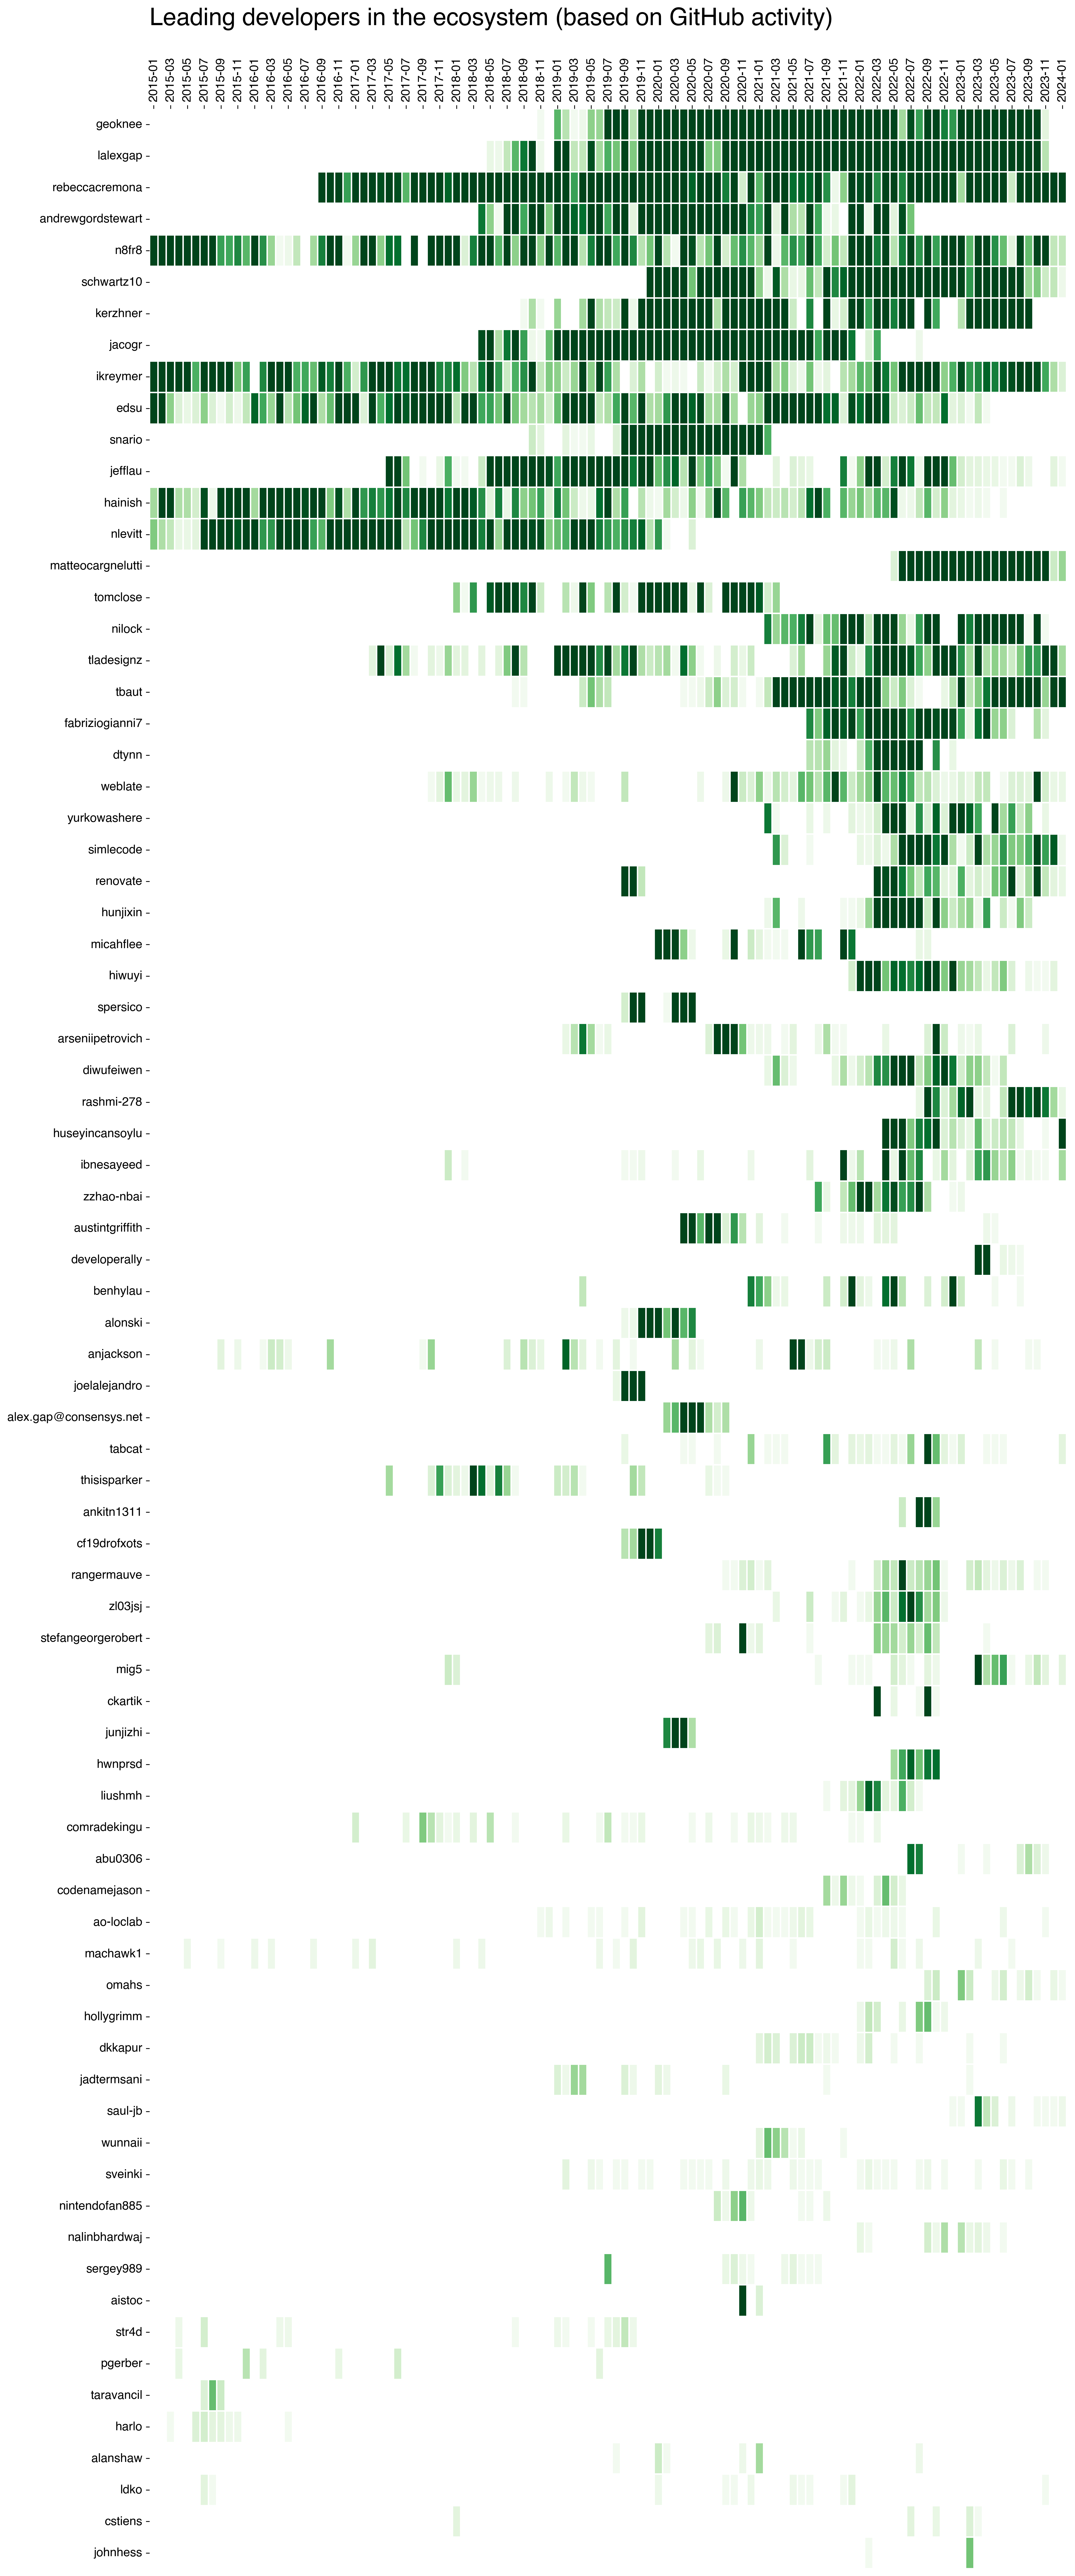

In [33]:
df_dev_activity['name'] = df_dev_activity['fromId'].map(devs_dict)
fig, ax = contribution_heatmap(
    df_dev_activity, 
    index_col="name", 
    column_col="month", 
    value_col="activity", 
    cmap='Greens', 
    vmax=30,
    dpi=300,
    sort_label_method='sum',
    figsize=(15,35)
)

ax.set_title("Leading developers in the ecosystem (based on GitHub activity)\n", fontweight="bold", loc='left', fontsize=24)